In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
res_folders=os.listdir('../../results/')

In [18]:
model_folder='/home/mara/multitask_adversarial/results//'
CONCEPT=['domain', 'ncount','narea', 'full_contrast']

In [19]:
import keras
keras.__version__
from sklearn.metrics import accuracy_score

In [4]:
'../../doc/data_shuffle.csv'

'../../doc/data_shuffle.csv'

In [5]:
## Loading OS libraries to configure server preferences
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
import setproctitle
SERVER_NAME = 'ultrafast'
EXPERIMENT_TYPE='test_domain'
import time
import sys
import shutil
## Adding PROCESS_UC1 utilities
sys.path.append('../../lib/TASK_2_UC1/')
from models import *
from util import otsu_thresholding
from extract_xml import *
from functions import *                   
sys.path.append('../../lib/')
from mlta import *
import math
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = str(0)# str(hvd.local_rank())
keras.backend.set_session(tf.Session(config=config))

verbose=1 
"""loading dataset files"""
#rank = MPI.COMM_WORLD.rank
cam16 = hd.File('/home/mara/adversarialMICCAI/data/ultrafast/cam16_500/patches.h5py',  'r', libver='latest', swmr=True)
all500 = hd.File('/home/mara/adversarialMICCAI/data/ultrafast/all500/patches.h5py',  'r', libver='latest', swmr=True)
extra17 = hd.File('/home/mara/adversarialMICCAI/data/ultrafast/extra17/patches.h5py','r', libver='latest', swmr=True)
tumor_extra17=hd.File('/home/mara/adversarialMICCAI/data/ultrafast/1129-1155/patches.h5py', 'r', libver='latest', swmr=True)
test2 = hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/ultrafast/test_data2/patches.hdf5', 'r', libver='latest', swmr=True)
pannuke= hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/pannuke/patches_fix.hdf5', 'r', libver='latest', swmr=True)

global datasetss
datasetss={'cam16':cam16,'all500':all500,'extra17':extra17, 'tumor_extra17':tumor_extra17, 'test_data2': test2, 'pannuke':pannuke}

global concept_db
concept_db = hd.File('../../data/normalized_cmeasures/concept_values_def.h5py','r')

#SYSTEM CONFIGS 
CONFIG_FILE = '../../doc/config.cfg'
COLOR = True
BATCH_SIZE = 32

# SAVE FOLD
f=open(model_folder+"/seed.txt","r")
seed=1001#int(f.read())
if verbose:  print(seed)
#f.write(str(seed))
f.close()


# SET PROCESS TITLE
setproctitle.setproctitle('{}'.format(EXPERIMENT_TYPE))

# SET SEED
np.random.seed(seed)
tf.set_random_seed(seed)

# DATA SPLIT CSVs 
train_csv=open('/mnt/nas2/results/IntermediateResults/Camelyon/train_shuffle.csv', 'r') # How is the encoding of .csv files ?
val_csv=open('/mnt/nas2/results/IntermediateResults/Camelyon/val_shuffle.csv', 'r')
test_csv=open('/mnt/nas2/results/IntermediateResults/Camelyon/test_shuffle.csv', 'r')
train_list=train_csv.readlines()
val_list=val_csv.readlines()
test_list=test_csv.readlines()
test2_csv = open('/mnt/nas2/results/IntermediateResults/Camelyon/test2_shuffle.csv', 'r')
test2_list=test2_csv.readlines()
test2_csv.close()
train_csv.close()
val_csv.close()
test_csv.close()
data_csv=open('../../doc/data_shuffle.csv', 'r')
data_list=data_csv.readlines()
data_csv.close()

# STAIN NORMALIZATION
def get_normalizer(patch, save_folder='../../results/'):
    normalizer = ReinhardNormalizer()
    normalizer.fit(patch)
    np.save('{}/normalizer'.format(save_folder),normalizer)
    np.save('{}/normalizing_patch'.format(save_folder), patch)
    #print('Normalisers saved to disk.')
    return normalizer
def normalize_patch(patch, normalizer):
    return np.float64(normalizer.transform(np.uint8(patch)))

global normalizer
db_name, entry_path, patch_no = get_keys(data_list[0])
normalization_reference_patch = datasetss[db_name][entry_path][patch_no]
normalizer = get_normalizer(normalization_reference_patch, save_folder='../../results/')

"""
Batch generators: 
They load a patch list: a list of file names and paths. 
They use the list to create a batch of 32 samples. 
"""

# Retrieve Concept Measures
def get_concept_measure(db_name, entry_path, patch_no, measure_type=''):
    if measure_type=='domain':
        return get_domain(db_name, entry_path)
    path=db_name+'/'+entry_path+'/'+str(patch_no)+'/'+measure_type.strip(' ')
    try:
        cm=concept_db[path][0]
        return cm
    except:
        print("[ERR]: {}, {}, {}, {} with path {}".format(db_name, entry_path, patch_no, measure_type, path))
        #import pdb; pdb.set_trace()
        return 1.
    
# BATCH GENERATORS
import keras.utils
class DataGenerator(keras.utils.Sequence):
    def __init__(self, patch_list, concept=CONCEPT, batch_size=32, shuffle=True, data_type=0):
        self.batch_size=batch_size
        self.patch_list=patch_list
        self.shuffle=shuffle
        self.concept = concept
        self.data_type=data_type
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.patch_list)/self.batch_size))
    
    def __getitem__(self, index):
        indexes=self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        patch_list_temp=[self.patch_list[k] for k in indexes]
        self.patch_list_temp=patch_list_temp
        return self.__data_generation(self), None
    
    def get(self, index):
        indexes=self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        patch_list_temp=[self.patch_list[k] for k in indexes]
        self.patch_list_temp=patch_list_temp
        return self.__data_generation(self), None
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.patch_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, patch_list_temp):
        patch_list_temp=self.patch_list_temp
        batch_x=np.zeros((len(patch_list_temp), 224,224,3))
        batch_y=np.zeros(len(patch_list_temp))
        i=0
        for line in patch_list_temp:
            db_name, entry_path, patch_no = get_keys(line)
            patch=datasetss[db_name][entry_path][patch_no]
            patch=normalize_patch(patch, normalizer)
            patch=keras.applications.inception_v3.preprocess_input(patch) 
            label = get_class(line, entry_path) 
            if self.data_type!=0:
                label=get_test_label(entry_path)
            batch_x[i]=patch
            batch_y[i]=label
            i+=1
        generator_output=[batch_x, batch_y]
        for c in self.concept:
            batch_concept_values=np.zeros(len(patch_list_temp))
            i=0
            for line in patch_list_temp:
                db_name, entry_path, patch_no = get_keys(line)
                batch_concept_values[i]=get_concept_measure(db_name, entry_path, patch_no, measure_type=c)
                i+=1
            if c=='domain':
                    batch_concept_values=keras.utils.to_categorical(batch_concept_values, num_classes=7)
            generator_output.append(batch_concept_values)
        return generator_output
    

1001
Using brightness standardization


In [6]:
#import matplotlib as mpl   
#mpl.use('Agg')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('tensorflow').disabled = True
from keras import *
import setproctitle
SERVER_NAME = 'ultrafast'
import time
import sys
import shutil
## Adding PROCESS_UC1 utilities
sys.path.append('../../lib/TASK_2_UC1/')
from models import *
from util import otsu_thresholding
from extract_xml import *
from functions import *                   
sys.path.append('../../lib/')
from mlta import *
import math
import keras.callbacks as callbacks
from keras.callbacks import Callback

In [7]:
keras.backend.clear_session()
""" 
Get trainable model with Hepistemic Uncertainty Weighted Loss 
"""
def get_trainable_model(baseline_model):
    inp = keras.layers.Input(shape=(224,224,3,), name='inp')
    outputs = baseline_model(inp)
    n_extra_concepts = len(outputs) -2
    print(n_extra_concepts)
    y_true=keras.layers.Input(shape=(1,),name='y_true')
    domain_true=keras.layers.Input(shape=(7,),name='domain_true')
    extra_concepts_true=[]
    for i in range(n_extra_concepts):
        print('extra_{}'.format(i))
        extra_true=keras.layers.Input(shape=(1,), name='extra_{}'.format(i))
        extra_concepts_true.append(extra_true)
    new_model_input=[inp, y_true, domain_true]
    loss_inputs=[y_true, domain_true]
    for i in range(len(extra_concepts_true)):
        new_model_input.append(extra_concepts_true[i])
        loss_inputs.append(extra_concepts_true[i])
    for out_ in outputs:
        loss_inputs.append(out_)
    out = CustomMultiLossLayer(nb_outputs=len(outputs), new_folder='')(loss_inputs)
    return Model(input=new_model_input, output=out)
""" 
LOSS FUNCTIONS
"""
def keras_mse(y_true, y_pred):
    return tf.reduce_mean(tf.keras.losses.mean_squared_error(y_true, y_pred))

def bbce(y_true, y_pred):
    # we use zero weights to set the loss to zero for unlabeled data
    verbose=0
    zero= tf.constant(-1, dtype=tf.float32)
    where = tf.not_equal(y_true, zero)
    where = tf.reshape(where, [-1])
    indices=tf.where(where) #indices where the item of y_true is NOT -1
    indices = tf.reshape(indices, [-1])
    sliced_y_true = tf.nn.embedding_lookup(y_true, indices)
    sliced_y_pred = tf.nn.embedding_lookup(y_pred, indices)
    n1 = tf.shape(indices)[0] #number of train images in batch
    batch_size = tf.shape(y_true)[0]
    n2 = batch_size - n1 #number of test images in batch
    sliced_y_true = tf.reshape(sliced_y_true, [n1, -1])
    n1_ = tf.cast(n1, tf.float32)
    n2_ = tf.cast(n2, tf.float32)
    multiplier = (n1_+ n2_) / n1_
    zero_class = tf.constant(0, dtype=tf.float32)
    where_class_is_zero=tf.cast(tf.reduce_sum(tf.cast(tf.equal(sliced_y_true, zero_class), dtype=tf.float32)), dtype=tf.float32)
    if verbose:
        where_class_is_zero=tf.Print(where_class_is_zero,[where_class_is_zero],'where_class_is_zero: ')
    class_weight_zero = tf.cast(tf.divide(n1_, 2. * tf.cast(where_class_is_zero, dtype=tf.float32)+0.001), dtype=tf.float32)
    
    if verbose:
        class_weight_zero=tf.Print(class_weight_zero,[class_weight_zero],'class_weight_zero: ')
    one_class = tf.constant(1, dtype=tf.float32)
    where_class_is_one=tf.cast(tf.reduce_sum(tf.cast(tf.equal(sliced_y_true, one_class), dtype=tf.float32)), dtype=tf.float32)
    if verbose:
        where_class_is_one=tf.Print(where_class_is_one,[where_class_is_one],'where_class_is_one: ')
        n1_=tf.Print(n1_,[n1_],'n1_: ')
    class_weight_one = tf.cast(tf.divide(n1_, 2. * tf.cast(where_class_is_one,dtype=tf.float32)+0.001), dtype=tf.float32)
    class_weight_zero =  tf.constant(23477.0/(23477.0+123820.0), dtype=tf.float32)
    class_weight_one =  tf.constant(123820.0/(23477.0+123820.0), dtype=tf.float32)
    A = tf.ones(tf.shape(sliced_y_true), dtype=tf.float32) - sliced_y_true 
    A = tf.scalar_mul(class_weight_zero, A)
    B = tf.scalar_mul(class_weight_one, sliced_y_true) 
    class_weight_vector=A+B
    ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=sliced_y_true,logits=sliced_y_pred)
    ce = tf.multiply(class_weight_vector,ce)
    return tf.reduce_mean(ce)

from keras.initializers import Constant
global domain_weight
global main_task_weight

class CustomMultiLossLayer(Layer):
    def __init__(self, new_folder='', nb_outputs=2, **kwargs):
        self.nb_outputs = nb_outputs
        self.is_placeholder = True
        super(CustomMultiLossLayer, self).__init__(**kwargs)
        
    def build(self, input_shape=None):
        # initialise log_vars
        self.log_vars = []
        for i in range(self.nb_outputs):
            self.log_vars += [self.add_weight(name='log_var' + str(i), shape=(1,),
                                              initializer=Constant(0.), trainable=True)]
        super(CustomMultiLossLayer, self).build(input_shape)
    """
    def multi_loss(self, ys_true, ys_pred):
        assert len(ys_true) == self.nb_outputs and len(ys_pred) == self.nb_outputs
        loss = 0
        for y_true, y_pred, log_var in zip(ys_true, ys_pred, self.log_vars):
            precision = K.exp(-log_var[0])
            loss += K.sum(precision * (y_true - y_pred)**2. + log_var[0], -1)
        return K.mean(loss)
    """
    def multi_loss(self,  ys_true, ys_pred):
        assert len(ys_true) == self.nb_outputs and len(ys_pred) == self.nb_outputs
        loss = 0
        i=0
        for y_true, y_pred, log_var in zip(ys_true, ys_pred, self.log_vars):
            precision =keras.backend.exp(-log_var[0]) 
            if i==0:
                pred_loss = bbce(y_true, y_pred)
                term = main_task_weight*precision*pred_loss + main_task_weight*0.5 * log_var[0]  
                #term=tf.Print(keras.backend.mean(term), [keras.backend.mean(term)], 'mean bbce: ')
            elif i==1:
                # I need to find a better way for this
                pred_loss = keras.losses.categorical_crossentropy(y_true, y_pred)
                #keras_mse(y_true, y_pred)
                term =  domain_weight * precision * pred_loss + domain_weight * log_var[0]
                #term=tf.Print(keras.backend.mean(term), [keras.backend.mean(term)], 'mean cce: ')
            else:
                pred_loss = keras_mse(y_true, y_pred)
                #pred_loss=tf.Print(pred_loss, [pred_loss], 'MSE: ')
                term = 0.5 * precision * pred_loss + 0.5 * log_var[0]
            loss+=term
            term = 0.
            i+=1
        return keras.backend.mean(loss)
    
    def call(self, inputs):
        ys_true = inputs[:self.nb_outputs]
        ys_pred = inputs[self.nb_outputs:]
        loss = self.multi_loss(ys_true, ys_pred)
        self.add_loss(loss, inputs=inputs)
        return keras.backend.concatenate(inputs, -1)

"""
EVALUATION FUNCTIONs
"""
def accuracy_domain(y_true,y_pred):
    y_p_r=np.round(y_pred)
    acc = np.equal(y_p_r, y_true)**1.
    acc = np.mean(np.float32(acc))
    return acc
def my_sigmoid(x):
    return 1 / (1 + np.exp(-x))
def my_accuracy_np(y_true, y_pred):
    sliced_y_pred = my_sigmoid(y_pred)
    y_pred_rounded = np.round(sliced_y_pred)
    acc = np.equal(y_pred_rounded, y_true)**1.
    acc = np.mean(np.float32(acc))
    return acc
def r_square_np(y_true, y_pred):
    SS_res =  np.sum(np.square(y_true - y_pred))
    SS_tot = np.sum(np.square(y_true - np.mean(y_true)))
    r2_mine=( 1 - SS_res/(SS_tot + keras.backend.epsilon()) )
    return ( 1 - SS_res/(SS_tot + keras.backend.epsilon()) )

global report_val_acc 
global report_val_r2
global report_val_mse
report_val_acc=[]
report_val_r2=[]
report_val_mse=[]

"""         
Building guidable model 
"""
def get_baseline_model(hp_lambda=0., c_list=[]):
    base_model = keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(224,224,3))
    layers_list=['conv2d_92', 'conv2d_93', 'conv2d_88', 'conv2d_89', 'conv2d_86']
    #layers_list=[]
    for i in range(len(base_model.layers[:])):
        layer=base_model.layers[i]
        if layer.name in layers_list:
            print layer.name
            layer.trainable=True
        else:
            layer.trainable = False
    feature_output=base_model.layers[-1].output
    gap_layer_output = keras.layers.GlobalAveragePooling2D()(feature_output)
    feature_output = Dense(2048, activation='relu', name='finetuned_features1',kernel_regularizer=keras.regularizers.l2(0.01))(gap_layer_output) 
    feature_output = keras.layers.Dropout(0.8, noise_shape=None, seed=None)(feature_output)
    feature_output = Dense(512, activation='relu', name='finetuned_features2',kernel_regularizer=keras.regularizers.l2(0.01))(feature_output)
    feature_output = keras.layers.Dropout(0.8, noise_shape=None, seed=None)(feature_output)
    feature_output = Dense(256, activation='relu', name='finetuned_features3',kernel_regularizer=keras.regularizers.l2(0.01))(feature_output)
    feature_output = keras.layers.Dropout(0.8, noise_shape=None, seed=None)(feature_output)
    grl_layer=GradientReversal(hp_lambda=hp_lambda)
    feature_output_grl = grl_layer(feature_output)
    domain_adversarial = keras.layers.Dense(7, activation = keras.layers.Activation('softmax'), name='domain_adversarial')(feature_output_grl)
    finetuning = Dense(1,name='predictions')(feature_output)
    ## here you need to check how many other concepts you have apart from domain adversarial
    # then you add one layer per each. 
    output_nodes=[finetuning, domain_adversarial]
    for c in c_list:
        if c!='domain':
            concept_layer=  keras.layers.Dense(1, activation = keras.layers.Activation('linear'), name='extra_{}'.format(c.strip(' ')))(feature_output)
            output_nodes.append(concept_layer)
    model = Model(input=base_model.input, output=output_nodes)
    model.grl_layer=grl_layer
    return model


In [20]:
main_task_weight=1. 
domain_weight = 1. #e-100
model=get_baseline_model(hpa_lambda=1., c_list=CONCEPT)
t_m = get_trainable_model(model)
#model=get_baseline_model(hp_lambda=1., c_list=CONCEPT)
#t_m = get_trainable_model(model)

KeyboardInterrupt: 

In [ ]:
t_m.load_weights('{}/best_model.h5'.format(model_folder))

In [10]:
BATCH_SIZE = 32
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
def evaluate(pred_, save_file=None, c_list=CONCEPT):
    y_true = pred_[:,0]
    domain_true = pred_[:,1:8]
    true_extra_concepts={}
    if len(c_list)>1:
        for i in range(1, len(c_list)):
            true_extra_concepts[i]=pred_[:,8+i]
    #print(i)
    y_pred = pred_[:,8+i]
    val_acc = my_accuracy_np(y_true, y_pred)
    domain_pred = pred_[:, 8+i+1:8+i+1+7]
    last_index=8+i+7
    pred_extra_concepts={}
    if len(c_list)>1:
        for i in range(1, len(c_list)):
            pred_extra_concepts[i]=pred_[:,last_index+i]
    val_acc_d = accuracy_domain(domain_true, domain_pred)
    val_r2={}
    val_mse={}
    if len(c_list)>1:
        for i in range(1, len(c_list)):
            val_r2[i] = r_square_np(true_extra_concepts[i], pred_extra_concepts[i])
            val_mse[i] = compute_mse(true_extra_concepts[i], pred_extra_concepts[i])
    
    extra_string=''
    if len(c_list)>1:
        for i in range(1, len(c_list)):
            extra_string=extra_string+" {}: r2 {}, mse {}; ".format(i, val_r2[i], val_mse[i])
    #print("Acc: {}, Acc domain: {}\n".format(val_acc, val_acc_d)+extra_string)
    if save_file is not None:
        save_file.write("Val acc: {}, acc_domain: {}\n".format(val_acc, val_acc_d)+extra_string)
    return y_true, domain_true, true_extra_concepts, y_pred, domain_pred, pred_extra_concepts
def compute_mse(labels, predictions):
    errors = labels - predictions
    sum_squared_errors = np.sum(np.asarray([pow(errors[i],2) for i in range(len(errors))]))
    mse = sum_squared_errors / len(labels)
    return mse
def evaluate_model(d_list, model, batch_size=BATCH_SIZE, test_type=''):
    batch_size=32
    t_gen=DataGenerator(d_list, concept=CONCEPT, batch_size=BATCH_SIZE, data_type=0)
    steps=len(d_list)//batch_size
    initial_lr = 1e-4
    opt = keras.optimizers.SGD(lr=initial_lr, momentum=0.9, nesterov=True)
    compile_model(t_m,opt,loss=None,metrics=None)
    callbacks = []
    y_true=np.zeros(len(d_list))
    y_pred=np.zeros((len(d_list),1))
    N=0
    all_true_domain=[]
    all_pred_domain=[]
    all_true_extra_cm={}#[]#np.zeros(len(d_list))
    all_pred_extra_cm={}#[]#np.zeros(len(d_list))
    batch_counter=0
    while N<len(d_list):
        #print N
        input_,_ = t_gen.__getitem__(batch_counter)
        pred_ = t_m.predict(input_)
        
        y_true_batch, d_true, true_ec, y_pred_batch, d_pred, pred_ec = evaluate(pred_)
        #maybe some import pdb here
        y_true[N:N+len(y_true_batch)]=y_true_batch.reshape(len(y_true_batch))
        y_pred[N:N+len(y_pred_batch)]=y_pred_batch.reshape(len(y_pred_batch),1)
        
        all_true_domain.append(d_true)
        all_pred_domain.append(d_pred)
        for extra_concept in true_ec.keys():
            try:
                all_true_extra_cm[extra_concept].append(true_ec[extra_concept])
            except:
                all_true_extra_cm[extra_concept]=[]
                all_true_extra_cm[extra_concept].append(true_ec[extra_concept])
        for extra_concept in pred_ec.keys():
            try:
                all_pred_extra_cm[extra_concept].append(pred_ec[extra_concept])
            except:
                all_pred_extra_cm[extra_concept]=[]
                all_pred_extra_cm[extra_concept].append(pred_ec[extra_concept])
        N+=len(y_pred_batch)
        batch_counter+=1
    #import pdb; pdb.set_trace()
    y_true=y_true.reshape((len(d_list),1))
    #y_pred=y_pred.reshape((len(d_list),1))
    acc = my_accuracy(y_true, y_pred).eval(session=tf.Session())
    sliced_y_pred = tf.sigmoid(y_pred)
    y_pred_rounded = K.round(sliced_y_pred)
    acc_sc = accuracy_score(y_pred_rounded.eval(session=tf.Session()), y_true)
    print('accuracy: ', acc_sc)
    
    y_pred = sliced_y_pred.eval(session=tf.Session())
    #sliced_y_pred = tf.sigmoid(y_pred)
    #y_pred_rounded = K.round(sliced_y_pred)
    auc_score=sklearn.metrics.roc_auc_score(y_true,sliced_y_pred.eval(session=tf.Session()))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(1):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc_score
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    auc_record = open('{}/auc_{}.txt'.format(model_folder,test_type), 'w')
    auc_record.write('{}'.format(roc_auc[0]))
    auc_record.close()
    return all_true_domain, all_true_extra_cm, all_pred_domain, all_pred_extra_cm

## Performance on Main Task
##### How do we do on the patch classification?

[ERR]: all500, normal/level7/centre2/patient040/node2/patches, 320, ncount with path all500/normal/level7/centre2/patient040/node2/patches/320/ncount
[ERR]: all500, normal/level7/centre2/patient040/node2/patches, 320, narea with path all500/normal/level7/centre2/patient040/node2/patches/320/narea
[ERR]: all500, normal/level7/centre2/patient040/node2/patches, 320, full_contrast with path all500/normal/level7/centre2/patient040/node2/patches/320/full_contrast
[ERR]: cam16, tumor/level7/centre0/patient070_Mask.tif/patches, 67, ncount with path cam16/tumor/level7/centre0/patient070_Mask.tif/patches/67/ncount
[ERR]: cam16, tumor/level7/centre0/patient070_Mask.tif/patches, 67, narea with path cam16/tumor/level7/centre0/patient070_Mask.tif/patches/67/narea
[ERR]: cam16, tumor/level7/centre0/patient070_Mask.tif/patches, 67, full_contrast with path cam16/tumor/level7/centre0/patient070_Mask.tif/patches/67/full_contrast
[ERR]: cam16, tumor/level7/centre0/patient070_Mask.tif/patches, 168, ncount 

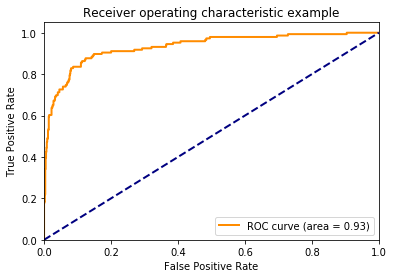

In [11]:
#keras.backend.get_session().run(tf.global_variables_initializer())
#t_m.load_weights(model_folder+'/best_model.h5')
all_true_domain, all_true_extra_cm, all_pred_domain, all_pred_extra_cm=evaluate_model(train_list[:1000],t_m, test_type='train')

[ERR]: tumor_extra17, tumor/level7/centre1/patient034/node3/patches, 483, ncount with path tumor_extra17/tumor/level7/centre1/patient034/node3/patches/483/ncount
[ERR]: tumor_extra17, tumor/level7/centre1/patient034/node3/patches, 483, narea with path tumor_extra17/tumor/level7/centre1/patient034/node3/patches/483/narea
[ERR]: tumor_extra17, tumor/level7/centre1/patient034/node3/patches, 483, full_contrast with path tumor_extra17/tumor/level7/centre1/patient034/node3/patches/483/full_contrast
('accuracy: ', 0.7999263080324245)


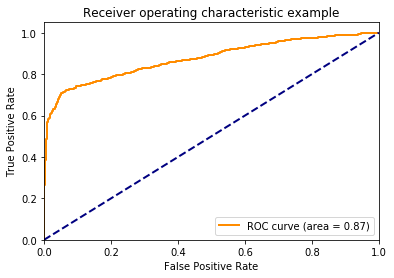

In [12]:
all_true_domain_internal_test, all_true_extra_cm_internal_test, all_pred_domain_internal_test, all_pred_extra_cm_internal_test=evaluate_model(test_list,t_m, test_type='internal')

('accuracy: ', 0.582)


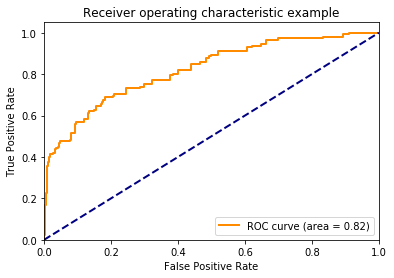

In [13]:
all_true_domain_external_test, all_true_extra_cm_external_test, all_pred_domain_external_test, all_pred_extra_cm_external_test=evaluate_model(test2_list,t_m, test_type='external')

# Performance on Auxiliary tasks
## Are we learning the concepts?

In [14]:
def compute_rsquared(labels, predictions):
    errors = labels - predictions
    sum_squared_errors = np.sum(np.asarray([pow(errors[i],2) for i in range(len(errors))]))
    # total sum of squares, TTS
    average_y = np.mean(labels)
    total_errors = labels - average_y
    total_sum_squares = np.sum(np.asarray([pow(total_errors[i],2) for i in range(len(total_errors))]))
    #rsquared is 1-RSS/TTS
    rss_over_tts =   sum_squared_errors/total_sum_squares
    rsquared = 1-rss_over_tts
    return rsquared
def compute_mse(labels, predictions):
    errors = labels - predictions
    sum_squared_errors = np.sum(np.asarray([pow(errors[i],2) for i in range(len(errors))]))
    mse = sum_squared_errors / len(labels)
    return mse

In [15]:
def accuracy_domain(y_true,y_pred):
    y_p_r = np.asarray([np.argmax(y_pred[i,:]) for i in range(len(y_pred[:,0]))])
    #y_p_r=np.round(y_pred)
    y_true = np.asarray([np.argmax(y_true[i,:]) for i in range(len(y_true[:,0]))])
    acc = np.equal(y_p_r, y_true)**1.
    acc = np.mean(np.float32(acc))
    return acc

In [16]:
cm_i=np.concatenate([true_cm for true_cm in all_true_domain])
cm_p_i=np.concatenate([pred_cm for pred_cm in all_pred_domain])
acc_d_i = accuracy_domain(cm_i, cm_p_i)
print 'Internal: ', acc_d_i

Internal:  0.473


In [17]:
#r2_e = compute_rsquared(all_cm_e, all_p_cm_e)
#mse_e = compute_mse(all_cm_e, all_p_cm_e)
cm_e=np.concatenate([true_cm for true_cm in all_cm_e])
cm_p_e=np.concatenate([pred_cm for pred_cm in all_p_cm_e])
acc_d_e = accuracy_domain(cm_e, cm_p_e)
print 'External: ', acc_d_e


NameError: name 'all_cm_e' is not defined

In [ ]:
test_type='internal'
auc_record = open('{}/concept_metrics_{}.txt'.format(model_folder,test_type), 'w')
auc_record.write('{}'.format(acc_d_i))
auc_record.close()
test_type='external'
auc_record = open('{}/concept_metrics_{}.txt'.format(model_folder,test_type), 'w')
auc_record.write('{}'.format(acc_d_e))
auc_record.close()

In [ ]:
cm_t=np.concatenate([true_cm for true_cm in all_cm_t])
cm_p_t=np.concatenate([pred_cm for pred_cm in all_p_cm_t])
acc_d_t = accuracy_domain(cm_t, cm_p_t)
print 'Train: ', acc_d_t


In [ ]:
val_r2=np.load('{}/val_r2_log.npy'.format(model_folder))

In [ ]:
plt.plot(val_r2)

In [ ]:
history=np.load('{}/training_log.npy'.format(model_folder), allow_pickle=True).item()

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

In [ ]:
f=open('{}/val_by_epoch.txt'.format(model_folder), 'r')
f_l=f.readlines()
val_acc=[]
val_r2=[]
val_mse=[]
for line in f_l:
    acc=line.split('Val acc: ')[1].split(', r2')[0]
    val_acc.append(acc)
    r2=line.split(', r2:')[1].split(', mse:')[0]
    mse=line.split(', mse:')[1].split('\n')[0]
    val_r2.append(r2)
    val_mse.append(mse)

In [ ]:
plt.plot(np.asarray(val_acc, dtype=np.float32))


In [ ]:
plt.plot(np.asarray(val_r2, dtype=np.float32))

In [ ]:
plt.plot(np.asarray(val_mse, dtype=np.float32))